# Cluster and summarize long-form audio using STT and GenAI

## Solution Overview

<p align="center">
  <img alt="Conceptual Flow" src="slides/Screenshot 2023-08-24 at 12.33.59 PM.png" width="100%">
</p>

## Setup

### Installs

In [1]:
# Install Vertex AI LLM SDK, langchain and dependencies
!pip install google-cloud-aiplatform vertexai langchain chromadb pydantic typing-inspect typing_extensions pandas datasets google-api-python-client pypdf faiss-cpu transformers config --upgrade --quiet

In [2]:
# # Automatically restart kernel after installs so that your environment can access the new packages
#import IPython

#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)

### Imports

In [3]:
from datetime import datetime
import time
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import networkx as nx
from networkx.algorithms import community

from IPython.display import Markdown

from langchain.llms import VertexAI
from langchain.embeddings import VertexAIEmbeddings
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain

import vertexai
from vertexai.language_models import TextGenerationModel, TextEmbeddingModel
from vertexai.preview.language_models import TextGenerationModel as TextGenerationModel_preview
from google.cloud import aiplatform
from google.cloud import storage
from google.cloud import bigquery

print("Vertex AI version: " + str(aiplatform.__version__))

2023-09-14 11:14:30.426238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Vertex AI version: 1.32.0


### Env variables and Setup

In [4]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [5]:
REGION = 'us-central1'
LOCATION = 'us'
GCS_BUCKET = PROJECT_ID
BLOB_PATH = 'audio_data/test'

In [6]:
DATASET = 'stt_genai'
TRANSCRIPT_TABLE_V1 = 'transcript_stt_genai_demo_v1'
TRANSCRIPT_TABLE_CHIRP = 'transcript_stt_genai_demo_chirp'
SUMMARY_TABLE = 'summary_stt_genai_demo'

In [7]:
# gcs client
gcs = storage.Client(project = PROJECT_ID)

# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

### Functions

In [8]:
# get audio data from GCS
def get_audio_data(gcs_bucket, blob_path):
    bucket = gcs.bucket(gcs_bucket)

    # Get the list of blobs
    blobs = bucket.list_blobs()

    # Loop through the blobs
    audio_data = []
    for blob in blobs:
        if blob.name.startswith(blob_path):
            if blob.name.endswith('.mp3'):
                #print(blob.name)
                audio_data.append([blob.name, blob.content_type, f'gs://{GCS_BUCKET}/{blob.name}'])
                
    return {
        'data_name': audio_data[-1][0],
        'data_type': audio_data[-1][1],
        'data_uri': audio_data[-1][2]
    }

In [9]:
# STT using cloud speech v2
from google.api_core.client_options import ClientOptions
from google.cloud.speech_v2 import SpeechClient as SpeechClient_v2
from google.cloud.speech_v2.types import cloud_speech as cloud_speech_v2

def transcribe_gcs_v2(gcs_uri: str) -> str:
    TIMEOUT_DEFAULT = 3600

    # Instantiates a client
    client = SpeechClient_v2(
        client_options=ClientOptions(
            api_endpoint="us-central1-speech.googleapis.com",
        )
    )
    
    config = cloud_speech_v2.RecognitionConfig(
        auto_decoding_config=cloud_speech_v2.AutoDetectDecodingConfig(),
        language_codes=["en-US"],
        model="chirp",
    )
    
    file_metadata = cloud_speech_v2.BatchRecognizeFileMetadata(uri=gcs_uri)

    request = cloud_speech_v2.BatchRecognizeRequest(
        recognizer=f"projects/{PROJECT_ID}/locations/{REGION}/recognizers/chirp-recognizer",
        config=config,
        files=[file_metadata],
        recognition_output_config=cloud_speech_v2.RecognitionOutputConfig(
            inline_response_config=cloud_speech_v2.InlineOutputConfig(),
        ),
    )

    # Transcribes the audio into text
    operation = client.batch_recognize(request=request)

    print("Waiting for operation to complete...")
    try:
        response = operation.result(timeout=TIMEOUT_DEFAULT)       # The default is 3600 seconds, 1 hour

    except:
        response = operation.result(timeout=1.5 * TIMEOUT_DEFAULT) # 5400 seconds, 1 hour and 30 minutes

    finally:
        response = operation.result(timeout=2 * TIMEOUT_DEFAULT)   # 7200 seconds, 2 hours

    return response


In [10]:
# create sentences and chunks for prompting
def create_sentences(segments, MIN_WORDS, MAX_WORDS):

    # Combine the non-sentences together
    sentences = []

    is_new_sentence = True
    sentence_length = 0
    sentence_num = 0
    sentence_segments = []

    for i in range(len(segments)):
        if is_new_sentence == True:
            is_new_sentence = False
        # Append the segment
        sentence_segments.append(segments[i])
        segment_words = segments[i].split(' ')
        sentence_length += len(segment_words)

        # If exceed MAX_WORDS, then stop at the end of the segment
        # Only consider it a sentence if the length is at least MIN_WORDS
        if (sentence_length >= MIN_WORDS and segments[i][-1] == '.') or sentence_length >= MAX_WORDS:
            sentence = ' '.join(sentence_segments)
            sentences.append({
            'sentence_num': sentence_num,
            'text': sentence,
            'sentence_length': sentence_length
            })
            # Reset
            is_new_sentence = True
            sentence_length = 0
            sentence_segments = []
            sentence_num += 1

    return sentences

def create_chunks(sentences, CHUNK_LENGTH, STRIDE):

    sentences_df = pd.DataFrame(sentences)

    chunks = []
    for i in range(0, len(sentences_df), (CHUNK_LENGTH - STRIDE)):
        chunk = sentences_df.iloc[i:i+CHUNK_LENGTH]
        chunk_text = ' '.join(chunk['text'].tolist())

        chunks.append({
            'start_sentence_num': chunk['sentence_num'].iloc[0],
            'end_sentence_num': chunk['sentence_num'].iloc[-1],
            'text': chunk_text,
            'num_words': len(chunk_text.split(' '))
        })
    
    chunks_df = pd.DataFrame(chunks)
    return chunks_df.to_dict('records')

def parse_title_summary_results(results):
    out = []
    for e in results:
        e = e.replace('\n', '')
        if '|' in e:
            processed = {'title': e.split('|')[0],
                        'summary': e.split('|')[1][1:]
                        }
        elif ':' in e:
            processed = {'title': e.split(':')[0],
                        'summary': e.split(':')[1][1:]
                        }
        elif '-' in e:
            processed = {'title': e.split('-')[0],
                        'summary': e.split('-')[1][1:]
                        }
        else:
            processed = {'title': '',
                        'summary': e
                        }
        out.append(processed)
    return out

In [11]:
# GenAI summary stage 1 using raw text chunks
def summary_stage_1(chunks_text):
    
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    map_prompt_template = """Summarize the key points of the following text. Include as much information as possible:

    {text}"""

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison-32k",
        max_output_tokens=1024,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in chunks_text]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_1_outputs_summary = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Summary creation - Stage 1: {total_time} minutes')

    return {
        'stage_1_outputs_summary': stage_1_outputs_summary
    }

In [12]:
# Run the community detection algorithm to determine distinct topics
def get_topics(stage_1_summaries, num_1_chunks, num_topics = 8, bonus_constant = 0.25, min_size = 3):
    # Use Vertex AI to embed the summaries and titles. Size of _embeds: (num_chunks x 768)
    vertex_embed = VertexAIEmbeddings()

    summary_embeds = np.array(vertex_embed.embed_documents(stage_1_summaries))
    
    # Get similarity matrix between the embeddings of the chunk summaries
    summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
    summary_similarity_matrix[:] = np.nan

    for row in range(num_1_chunks):
        for col in range(row, num_1_chunks):
            # Calculate cosine similarity between the two vectors
            similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
            summary_similarity_matrix[row, col] = similarity
            summary_similarity_matrix[col, row] = similarity
    
    # Draw a heatmap with the summary_similarity_matrix
    plt.figure()
    # Color scheme blues
    plt.imshow(summary_similarity_matrix, cmap = 'Blues')
    
    title_similarity = summary_similarity_matrix

    proximity_bonus_arr = np.zeros_like(title_similarity)
    for row in range(proximity_bonus_arr.shape[0]):
        for col in range(proximity_bonus_arr.shape[1]):
            if row == col:
                proximity_bonus_arr[row, col] = 0
            else:
                proximity_bonus_arr[row, col] = 1/(abs(row-col)) * bonus_constant
        
    title_similarity += proximity_bonus_arr

    title_nx_graph = nx.from_numpy_array(title_similarity)

    desired_num_topics = num_topics
    # Store the accepted partitionings
    topics_title_accepted = []

    resolution = 0.85
    resolution_step = 0.01
    iterations = 40

    # Find the resolution that gives the desired number of topics
    topics_title = []
    while len(topics_title) not in [desired_num_topics, desired_num_topics + 1, desired_num_topics + 2]:
        topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
        resolution += resolution_step
    topic_sizes = [len(c) for c in topics_title]
    sizes_sd = np.std(topic_sizes)
    modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

    lowest_sd_iteration = 0
    # Set lowest sd to inf
    lowest_sd = float('inf')

    for i in range(iterations):
        topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
        modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

        # Check SD
        topic_sizes = [len(c) for c in topics_title]
        sizes_sd = np.std(topic_sizes)

        topics_title_accepted.append(topics_title)

        if sizes_sd < lowest_sd and min(topic_sizes) >= min_size:
            lowest_sd_iteration = i
            lowest_sd = sizes_sd
      
    # Set the chosen partitioning to be the one with highest modularity
    topics_title = topics_title_accepted[lowest_sd_iteration]
    print(f'Best SD: {lowest_sd}, Best iteration: {lowest_sd_iteration}, Number of topics (actual): {len(topics_title)}, Number of topics (setting): {desired_num_topics}')

    topic_id_means = [sum(e)/len(e) for e in topics_title]
    # Arrange title_topics in order of topic_id_means
    topics_title = [list(c) for _, c in sorted(zip(topic_id_means, topics_title), key = lambda pair: pair[0])]
    # Create an array denoting which topic each chunk belongs to
    chunk_topics = [None] * title_similarity.shape[0]
    for i, c in enumerate(topics_title):
        for j in c:
            chunk_topics[j] = i
            
    return {
        'chunk_topics': chunk_topics,
        'topics': topics_title
    }

In [13]:
# GenAI summary stage 2 referencing topics and creation of articles
def summary_stage_2(summary_data, topics, summary_num_words = 250):
    
    start_time = time.time()
  
    # Prompt to get title and summary for each chunk
    MAP_PROMPT_TEMPLATE = """Write a """ + str(summary_num_words) + """ word summary of the following text.  Include as much information as possible:
  
    {text}
    """
    
    map_prompt = PromptTemplate(template=MAP_PROMPT_TEMPLATE, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison-32k",
        max_output_tokens=512,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
  
    topics_data = []
    for c in topics:
        topic_data_temp = [stage_1_summaries[chunk_id] for chunk_id in c]
        topic_data_temp = '. '.join(topic_data_temp)
        topics_data.append(topic_data_temp)

    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in topics_data]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_2_outputs_summary = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Summary creation - Stage 2: {total_time} minutes')

    return {
        'stage_2_outputs_summary': stage_2_outputs_summary
    }

def title_stage_2(summary_data, topics, summary_num_words = 250):
    
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    MAP_PROMPT_TEMPLATE = """Write a short title of the following text.  Do not include an explanation:

    {text}
    """

    map_prompt = PromptTemplate(template=MAP_PROMPT_TEMPLATE, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison-32k",
        max_output_tokens=256,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
        
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in summary_data]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_2_outputs_title = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Title creation - Stage 2: {total_time} minutes')

    return {
        'stage_2_outputs_title': stage_2_outputs_title
    }

def article_stage_2(stage_1_summaries, num_drafts=1):
    # set number of drafts to generate
    NUM_DRAFTS = num_drafts

    # Query Palm 2 to get a summary and title for each topic
    drafts = []
    for i in range(0, NUM_DRAFTS):
        print(f"Draft {i}")
        stage_2_outputs_summary = summary_stage_2(stage_1_summaries, topics, summary_num_words = 250)['stage_2_outputs_summary']
        stage_2_outputs_title = title_stage_2(stage_2_outputs_summary, topics, summary_num_words = 250)['stage_2_outputs_title']
        drafts.append([i+1, stage_2_outputs_title, stage_2_outputs_summary])
    
    return {
        'drafts': drafts
    }

## Data: Get data from GCS

Can loop through GCS to pick up multiple files.  This iteration is built for one file at a time but easy to update.

Loop through GCS bucket(s) for audio files to transcribe

In [14]:
sample_uri = get_audio_data(GCS_BUCKET, BLOB_PATH)['data_uri']
print(sample_uri)

gs://mg-ce-demos/audio_data/test/Mapping_uncharted_undersea_volcanoes,_and_elephant_seals_dive_deep_to_sleep.mp3


## Data: Transcribe audio and stringify

Until we can associate specific comments with specific people (e.g. using something like Speaker ID), speaker diarization doesn't add much value.  In v2, this was removed so we could test with the new Chirp model which did appear to improve accuracy of the transcription.

Function to transcribe audio, including speaker diarization and other features

In [15]:
## BQ table check
from google.cloud.exceptions import NotFound

table_id = f"{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}"

prior_transcription=False
try:
    bq.get_table(table_id)  # Make an API request.
    print("Table {} already exists.".format(table_id))
    if bq.query(f"SELECT COUNT(*) FROM {table_id}").result().total_rows == 0:
        print("The table is empty")
        start_time = time.time()

        response = transcribe_gcs_v2(sample_uri)
        
        order = 0

        transcript_df2 = pd.DataFrame(columns=['file', 'order', 'text'])

        for result in response.results[sample_uri].transcript.results:
            transcript_df2.loc[len(transcript_df2.index)] = [sample_uri, order, result.alternatives[0].transcript]
            order += 1

        transcript_df2.head()
        transcript_string = transcript_df2['text'].str.cat(sep=' ')

        table_id = f'{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}'

        job_config = bigquery.LoadJobConfig(
            write_disposition=bigquery.job.WriteDisposition.WRITE_TRUNCATE
        )

        job = bq.load_table_from_dataframe(
            transcript_df2, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        table = bq.get_table(table_id)  # Make an API request.
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
        )

        end_time = time.time()
        total_time = (end_time - start_time)/60
        print(f'{total_time} minutes')
    else:
        print("The table is not empty")
        prior_transcription=True
        query = """
        SELECT
          *
        FROM `{0}`
        """.format(table_id)
        transcript_df2 = bq.query(query).to_dataframe()
        transcript_df2 = transcript_df2.sort_values(by=['order'])
        transcript_string = transcript_df2['text'].str.cat(sep=' ')
        transcript_string = transcript_string.replace('a.m.', 'am')
        transcript_string = transcript_string.replace('p.m.', 'pm')
        transcript_string = transcript_string.replace('.com', ' dot com')

except NotFound:
    print("Table {} is not found.".format(table_id))
    start_time = time.time()

    response = transcribe_gcs_v2(sample_uri)
    
    order = 0

    transcript_df2 = pd.DataFrame(columns=['file', 'order', 'text'])

    for result in response.results[sample_uri].transcript.results:
        transcript_df2.loc[len(transcript_df2.index)] = [sample_uri, order, result.alternatives[0].transcript]
        order += 1
        
    transcript_df2.head()
    transcript_string = transcript_df2['text'].str.cat(sep=' ')
    transcript_string = transcript_string.replace('a.m.', 'am')
    transcript_string = transcript_string.replace('p.m.', 'pm')
    transcript_string = transcript_string.replace('.com', ' dot com')
    transcript_string = transcript_string.replace('.org', ' dot org')
    
    table_id = f'{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}'

    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.job.WriteDisposition.WRITE_TRUNCATE
    )

    job = bq.load_table_from_dataframe(
        transcript_df2, table_id, job_config=job_config
    )
    job.result()  # Wait for the job to complete.
    table = bq.get_table(table_id)  # Make an API request.
    print(
        "Loaded {} rows and {} columns to {}".format(
            table.num_rows, len(table.schema), table_id
        )
    )

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'{total_time} minutes')


Table mg-ce-demos.stt_genai.transcript_stt_genai_demo_chirp already exists.
The table is not empty


Build transcription, by speaker, grabbing words passing the confidence threshold

In [16]:
len(transcript_string)

35973

## 32K Model Summarization Test

In [17]:
textgen_model_32k = TextGenerationModel_preview.from_pretrained('text-bison-32k')

In [18]:
transcript_string_32k = transcript_string[0:30000]
len(transcript_string_32k)

30000

In [19]:
# 32k model summarization test
# Ask the LLM
prompt = """Summarize the key points of the text below.  Write the summary in bullet form with 1-2 sentences per key point.

Text:
{}""".format(transcript_string_32k)

# Send prompt to LLM
response_32k = textgen_model_32k.predict(
   (prompt),
    max_output_tokens=2000,
    temperature=0.4,
    top_p=0.8,
    top_k=40,
)
display(Markdown(str(response_32k)))

 - The ocean is mostly unmapped. Only about 25% of the ocean floor has been charted.
- New research nearly doubled the number of known seamounts, underwater volcanoes, from 2500 to over 19,000.
- Seamounts are important for understanding the ocean's circulation and the distribution of life in the ocean.
- Elephant seals are able to sleep while diving underwater.
- They sleep in short periods of about 5 minutes at a time and can sleep for a total of 2-10 hours per day.
- While sleeping, they flip upside down and spin in a circle, which may help them to conserve energy and avoid predators.
- Addiction is a chronic mental health condition that kills hundreds of thousands of Americans every year.
- Researchers define addiction as a compulsive behavior that persists despite clear evidence suggesting that the behavior should stop.
- Addiction has a devastating impact on society, including causing premature death, and negatively impacting every aspect of life.
- The number of addiction-related deaths has increased dramatically in recent years, with over 100,000 Americans dying each year from drug overdoses.
- Factors contributing to the increased instance of addiction include the excessive consumption of opioids and other illicit drugs in the United States.
- Advances in the science of addiction in recent years have included a better understanding of how drugs of abuse act on the brain's reward pathways, the role of genetics in addiction, and the development of new medications to treat addiction.

## Create sentences and chunks

After transcription, we need to isolate sentences, and create chunks of content.  Unlikely we will get much meaningful context from individual sentences.  Also, we don't want to lose context through chunking so we also will overlap when we combine sentences (i.e. sentences->chunks 1-2-3-4, 2-3-4-5, 3-4-5-6)

In [20]:
# Get segments from txt by splitting on .
segments =  transcript_string.split('.')
# Put the . back in
segments = [segment + '.' for segment in segments]
# Further split by comma
#segments = [segment.split(',') for segment in segments]
# Flatten
#segments = [item for sublist in segments for item in sublist]

In [21]:
# define chunk size and overlap
sentences = create_sentences(segments, MIN_WORDS=10, MAX_WORDS=100)
chunks = create_chunks(sentences, CHUNK_LENGTH=5, STRIDE=1)
chunks_text = [chunk['text'] for chunk in chunks]

In [22]:
print(len(chunks_text))
#chunks_text

33


## Stage 1: Get Chunk Summaries

Now we create our first summaries and titles based on the chunks of sentences we created from the transcriptions.  This is done using langchain and chaining prompts to create the summary and subsequently the titles.  These can be accomplished in a single step but I found the outputs not as good as doing them sequentially.

In [23]:
# Run Stage 1 Summarizing
stage_1_summaries = summary_stage_1(chunks_text)['stage_1_outputs_summary']

Summary creation - Stage 1: 19.711163187026976 minutes


In [24]:
# minor data cleanup
stage_1_summaries = [" " if x == '' else x for x in stage_1_summaries]
stage_1_summaries = [string.replace('\n', ' ') for string in stage_1_summaries]

## Generate embeddings for titles and summaries, and cluster into distinct topics

Using the stage 1 summaries, now we group them into common topics using cosine similarity and Louvain community detection.  This is necessary as the content contains many different topics, which when combining will make it hard for LLMs to produce concise content.  This step in the process produces the final context for creating final summaries / articles for each topic.

Best SD: 0.9270248108869579, Best iteration: 0, Number of topics (actual): 8, Number of topics (setting): 8


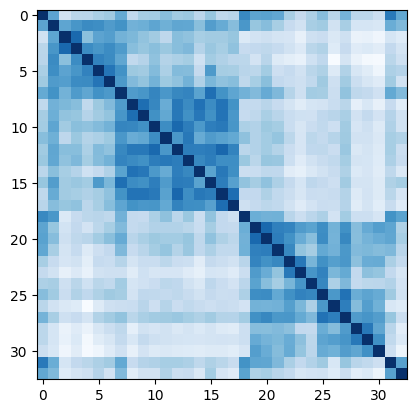

In [25]:
# Set num_topics to be 1/4 of the number of chunks, or 12, which ever is smaller
num_1_chunks = len(stage_1_summaries)
NUM_TOPICS = min(int(num_1_chunks / 4), 12)
topics_out = get_topics(stage_1_summaries, num_1_chunks, num_topics = NUM_TOPICS, bonus_constant = 0.3)
chunk_topics = topics_out['chunk_topics']
topics = topics_out['topics']

In [26]:
topics

[[1, 2, 3, 4, 5, 6],
 [8, 9, 7],
 [10, 11, 12, 13],
 [16, 17, 14, 15],
 [18, 19, 20, 21],
 [32, 0, 31],
 [24, 25, 22, 23],
 [26, 27, 28, 29, 30]]

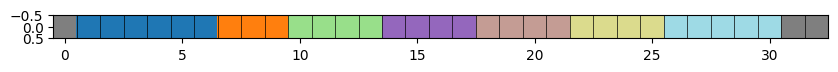

In [27]:
# Plot a heatmap of this array
plt.figure(figsize = (10, 4))
plt.imshow(np.array(chunk_topics).reshape(1, -1), cmap = 'tab20')
# Draw vertical black lines for every 1 of the x-axis 
for i in range(1, len(chunk_topics)):
    plt.axvline(x = i - 0.5, color = 'black', linewidth = 0.5)

## Stage 2: Final Summaries

Using the topics identified prior to this step, we use the same prompt chaining approach to create a summary then title for each topic.  At this point, we have a **first draft** for each topic where the LLM was able to produce an informative article and title.

### v2

In [28]:
drafts = article_stage_2(stage_1_summaries, num_drafts=1)['drafts']

Draft 0
Summary creation - Stage 2: 5.361589701970418 minutes
Title creation - Stage 2: 4.169548483689626 minutes


In [29]:
display(Markdown('# DRAFT direct 32K summarization'))
display(Markdown(str(response_32k)))

# DRAFT direct 32K summarization

 - The ocean is mostly unmapped. Only about 25% of the ocean floor has been charted.
- New research nearly doubled the number of known seamounts, underwater volcanoes, from 2500 to over 19,000.
- Seamounts are important for understanding the ocean's circulation and the distribution of life in the ocean.
- Elephant seals are able to sleep while diving underwater.
- They sleep in short periods of about 5 minutes at a time and can sleep for a total of 2-10 hours per day.
- While sleeping, they flip upside down and spin in a circle, which may help them to conserve energy and avoid predators.
- Addiction is a chronic mental health condition that kills hundreds of thousands of Americans every year.
- Researchers define addiction as a compulsive behavior that persists despite clear evidence suggesting that the behavior should stop.
- Addiction has a devastating impact on society, including causing premature death, and negatively impacting every aspect of life.
- The number of addiction-related deaths has increased dramatically in recent years, with over 100,000 Americans dying each year from drug overdoses.
- Factors contributing to the increased instance of addiction include the excessive consumption of opioids and other illicit drugs in the United States.
- Advances in the science of addiction in recent years have included a better understanding of how drugs of abuse act on the brain's reward pathways, the role of genetics in addiction, and the development of new medications to treat addiction.

In [30]:
for i in range(len(drafts)):
    display(Markdown('# DRAFT ' + str(drafts[i][0])))
    for j in range(len(drafts[i][1])):
        if drafts[i][1][j] != "":
            if drafts[i][2][j] != "":
                display(Markdown('### ' + drafts[i][1][j]))
                display(Markdown(drafts[i][2][j]))
                #print(drafts[i][2][j])
                print('------------------------')

# DRAFT 1

###  Discovery of 19,000 New Seamounts

 This week on the podcast, Sarah Cresty discusses the discovery of numerous submarine volcanoes known as seamounts, which nearly doubled the previously known number.  Next, Jessica Kendle Bar  joins the show to talk about her research on the sleep patterns of elephant seals, which spend most of their time in water.  In a sponsored segment, Jackie Oburst interviews addiction researchers Eric Nestler and Paul Kenny about the latest findings and future directions in the field of addiction.  Finally, it is noted that only a small portion of the ocean floor has been mapped or charted.  Only about 25% of the ocean floor has been charted or mapped.  - We don't know where all the big dips like trenches are or the big peaks like seamounts.  - The ocean is mysterious because it's covered in water, which makes it difficult to see what's down there.  - The best method we have for mapping the ocean is sonar, but it's expensive and time-consuming.  - Unmapped areas of the ocean can be dangerous for ships and submarines.  - The best method for mapping the ocean is sonar, but it is expensive and we have only mapped 25% of the ocean with it.    - Seamounts are a hazard for submarines, and there have been several incidents where US Navy submarines have run into uncharted seamounts.    - The new study used radar-equipped satellites to measure the height of the ocean worldwide and detect changes in slope in the water at the ocean surface.    - These changes in slope can indicate the gravity of seamounts underwater, and the study was able to identify over 19,000 new seamounts.    - We previously knew about about 2500 seamounts, and the new study was able to identify many smaller seamounts that we were not previously aware of.  Scientists have discovered 19,000 new seamounts, bringing the total number known to 21,500.  The new seamounts were discovered using improved satellite data.  Seamounts are underwater volcanoes that are at least a kilometer high.  The distribution of the new seamounts is similar to that of the previously known seamounts.  The text discusses the significance of newly discovered seamounts and their implications in various fields. The key points are as follows:   1.  New seamounts have been discovered in unexpected places, including around Antarctica

------------------------


###  Elephant Seal Sleep Patterns

 Northern elephant seals spend most of their time on long foraging dives that go very deep, with only one to two minutes at the surface at a time. They come on land twice a year to breed and molt, and spend a lot of time sleeping during that time, but that's not the most accurate representation of their activity budgets when they're out at sea. Other marine mammals, such as dolphins and seals, can sleep in just half of their brain at a time, which allows them to keep one eye open and monitor predators while they're getting the benefits of sleep for half their brain. 

Whales, dolphins, and seals can sleep in just half of their brain at a time, which is called unihemispheric sleep. This allows them to keep one eye open and monitor predators while they are getting the benefits of sleep for half of their brain. The first night effect is a documented effect where people are slightly more aware when they go to a new place. This is because there is some evidence that there is a little bit of asymmetry in the degree to which each of the hemispheres are engaging in slow-wave sleep. 

A new method for detecting underwater methane seeps using satellite observations has been developed. The method was developed by Paul Wennberg and his colleagues at Caltech, and it involves using a satellite to measure the amount of methane in the atmosphere. When methane seeps from the ocean floor, it enters the atmosphere and can be detected by satellites. The new method is more efficient than previous methods, which involved using ships or aircraft to measure methane levels. The new method can also be used to detect methane seeps in remote areas that are difficult to reach by ship or aircraft. 

A study conducted by Jessica Kendall-Bar and her colleagues at the University of California, Santa Cruz looked at the sleep patterns of elephant seals. Elephant seals spend most of their lives in the water, and they need to come to the surface to breathe. This means that they can't sleep deeply for long periods of time, because they need to wake up to breathe. 

Kendall-Bar and her colleagues found that elephant seals have a unique sleep pattern. They sleep in short bursts, and they wake up frequently to breathe. This sleep pattern allows them to get the rest they need without being at risk of drowning.

------------------------


###  Monitoring the Mysterious Underwater World of Elephant Seals

 The study observed elephant seals, which spend a significant amount of time in deep water and hold their breath for extended periods. To monitor their behavior, sleep monitors and motion sensors were attached to the seals. The data collected provided insights into their diving patterns and movements. The researcher's aim was to gain a better understanding of the seals' underwater experience.

The speaker is passionate about creating data-driven animations that show the behavior of seals underwater. They built tools to visualize the seals' movements, including their pitch, roll, and swimming frequency. The animations also show the seals' sleep spirals, which are beautiful patterns that the seals create while sleeping underwater.

The speaker also discusses the sleep moderate, which is a device used to measure brain activity during sleep. The same sensors used in human sleep studies are used on the seals. The speaker has even tried out the methods on themselves, floating in shallow water and trying to sleep to see if the sensors were working properly.

Elephant seals are large animals and can be dangerous to work with. They are often sedated to ensure the safety of the crew and the animals.

Elephant seals were tagged with headcaps that monitored sleep and data loggers that stored the data. The study found that elephant seals sleep in short bursts, with an average sleep time of about 5 minutes. They spend most of their time in a state of quiet rest, which is characterized by slow, regular breathing and low levels of muscle activity.

During deep sleep, elephant seals experience periods of rapid eye movement (REM), which is associated with dreaming. REM sleep is characterized by fast, irregular breathing and high levels of muscle activity. The study also found that elephant seals spend more time in deep sleep when they are in deeper water. This suggests that deep sleep may be important for helping elephant seals to conserve energy when they are far from land.

------------------------


###  Addiction: A Medical Problem That Needs Medical Solutions

 The Science Postdoctoral Fellow at the Scripps Institution of Oceanography at UC San Diego is Jessica Kendall Bar. The paper discussed in the podcast is available at science.org/podcast. Jackie Oburst, a custom publishing assistant editor, chats with Eric Nestler and Paul Kenny, two experts on addiction, about the latest research in the field. The podcast is sponsored by the Icon School of Medicine at Mount Sinai.
Addiction is a chronic mental health condition that kills hundreds of thousands of Americans every year. It can destroy marriages, friendships, and careers, and threaten a person's basic health and safety. Addiction is a medical problem that needs medical solutions.
Two renowned experts on addiction are Dr. Nora Volkow, Director of the National Institute on Drug Abuse, and Dr. Charles O'Brien, Professor of Psychiatry at the University of Pennsylvania. They discuss the latest research on addiction and how it can be treated.
Addiction is a complex disease that affects millions of people worldwide. The science of addiction is rapidly evolving, and new insights into the underlying mechanisms of addiction are emerging all the time. Drs. Eric Nessler and Paul Kenny are two of the world's leading experts on addiction. They have co-authored an upcoming article about the science of addiction in a neuroscience supplement of Science. Their laboratory studies the molecular mechanisms of drug addiction and depression in animal models. They are also working to develop new treatments for addiction.
Addiction is a psychiatric syndrome that can only be diagnosed by talking to a person or their family members and finding out what types of abnormal behaviors they exhibit. Researchers and clinicians do not define addiction the same way. Dr. Paul Kenny is a Ward Coleman's professor and chair of the Nash Family Department of neuroscience as well as the director of the Drug Discovery Institute at the Ikon School of Medicine at Mount Sini. Dr. Kenny's research involves the study of behavioral paradigms, physiological analyses and the molecular underpinnings of neurobehavioral disorders such as schizophrenia and drug addiction.

------------------------


###  Science Podcast: The Science of Sound

 The Science Magazine Podcast is a podcast that covers a wide range of scientific topics.  This episode is about the science of sound.  The podcast is hosted by Erica Burk, director and senior editor of Custom Publishing, and Jackie Oburst. 
     The guests are Dr. Eric Topol, a cardiologist and geneticist, and Dr. Robert Wachter, a professor of medicine at the University of California, San Francisco.  Dr. Topol discusses how technology is changing the way we diagnose and treat diseases.  Dr. Wachter discusses how the healthcare system is changing and how it needs to change in order to meet the needs of the future.  The podcast is sponsored by the Icahn School of Medicine at Mount Sinai, a leading research medical school in New York City.  Researchers are working to advance understanding of the brain and improve care for disorders like depression, dementia, and drug addiction.  A special supplement to Science magazine, prepared by the Icon School of Medicine in partnership with Science, provides more information.  The supplement can be found on the Science website by searching for "Frontiers of Medical Research-Brain Science."

------------------------


###  Drug Overdose Deaths in the United States

 The speaker discusses the issue of drug overdose deaths in the United States. They point out that the number of deaths has increased dramatically since the pandemic, with an estimated 100,000 Americans dying each year from drug overdoses. This number is more than the number of American combat troops who died during the Vietnam War. The speaker expresses concern that the United States does not seem to be able to marshal the resources to address this issue. 
     One of the major reasons for the increased instance of drug overdose deaths is the excessive amounts of opioids that are consumed in the United States. The speaker also points out that other drugs, such as cocaine and methamphetamine, are also contributing to the increase in deaths. 
     Addiction is a psychiatric syndrome that can only be diagnosed by talking to a person or their family members to find out what types of abnormal behaviors they exhibit. There is no blood test, genetic test, or brain scan that can be used to diagnose addiction. Addiction is a compulsive behavior that persists despite clear evidence suggesting that the behavior should stop, and the behavior is directed towards obtaining a drug of abuse. 
     Addiction has a devastating impact on society. The economic costs of addiction are estimated to be in the billions of dollars each year. In the United States, an estimated 23.5 million people aged 12 or older had a substance use disorder in 2017. Addiction can lead to a number of health problems, including heart disease, stroke, cancer, liver disease, HIV/AIDS, and mental health problems. Addiction can also lead to social problems, such as unemployment, homelessness, crime, incarceration, child abuse, and neglect. 
     Addiction has a devastating impact on society. In the United States, the opioid epidemic is a leading cause of premature death. Illicit drug use has negative consequences on every aspect of life and society. Addiction-related deaths are on the rise. Before the pandemic, about 70,000 Americans died every year of a drug overdose, the vast majority of which were unintentional.

------------------------


###  Brain Regions, Molecules, and Behavior: Understanding Drug Addiction and Its Treatment

 Reward pathways are ancient parts of the brain that regulate our responses to rewards in the environment. When we take a drug of abuse, our brain experiences it as the most rewarding experience possible, even though it isn't. This corrupts the brain's ability to analyze rewards, and an addicted individual is no longer rewarded by natural things. Instead, they require the sledgehammer effects of a drug of abuse to feel normal. This is why people with addictions are driven so strongly to take drugs. Research has identified brain regions involved in regulating responses to drugs of abuse and the chemical changes they produce to cause addiction. Molecular biology studies focus on changes in gene expression within nerve cells in brain reward regions that drive addiction behavior. Understanding the fundamental actions of drugs of abuse in the brain involves molecular, cellular, circuit levels, and underlying genetics. Medications like buprenorphine and methadone can be effective treatments for opioid addiction. The most promising trend in drug addiction treatment is the advancement of compounds through preclinical development and into human clinical trials. Human experiments are necessary to guide preclinical drug development and increase the likelihood of generating effective therapeutics. Behavioral therapies can be effective interventions for substance use disorders. Surprisingly little is known about the biological mechanisms of action of behavioral therapies. Behavioral therapies combined with medication are currently the most effective way of treating substance use disorders.

------------------------


## UI (WIP)

In [31]:
def upload_file(file):
    file_path = file.name
    file_name = os.path.basename(file_path)
    bucket = gcs.bucket(GCS_BUCKET)
    blob = bucket.blob(f'audio_data/cumulus/{file_name}')
    blob.upload_from_filename(f'{file_path}')
    #print("Uploaded")
    
    gcs_path = f'gs://{GCS_BUCKET}/{blob.name}'
    
    return gcs_path
    
#with gr.Blocks() as demo:
#    file_output = gr.File()
#    upload_button = gr.UploadButton("Click to Upload a File", file_types=["audio"])
#    upload_button.upload(upload_file, upload_button, file_output)

#demo.launch(share=False, debug=False)

In [32]:
# create a function that pulls all the steps together
def article_builder(gcs_uri):
    

IndentationError: expected an indented block (754168372.py, line 3)

In [ ]:
get_audio_data('mg-ce-demos')

In [ ]:
import gradio as gr

demo = gr.Blocks()

with demo:
    audio_file = gr.Audio(type="filepath")
    text = gr.Textbox()
    label = gr.Label()

    b1 = gr.Button("Upload")
    b2 = gr.Button("Get GCS URI")
    b3 = gr.Button("Create Articles")

    b1.click(upload_file, inputs=audio_file, outputs=text)
    b2.click(get_audio_data, inputs=text, outputs=label)

if __name__ == "__main__":
    demo.launch()

In [ ]:

with gr.Blocks() as demo:
    gr.Markdown(
    """
    ## Audio to Articles
    """)
    #with gr.Row():
    #    file_output = gr.File()
    #    upload_button = gr.UploadButton("Click to Transcribe and Draft Articles", file_types=["audio"])
    #    upload_button.upload(upload_file, upload_button, file_output)  
        
    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(label="Task", placeholder="Cloud Bucket Name")
    
    with gr.Row():
        find_gcs_uri = gr.Button("Select Audio File")
        
    with gr.Row():
        label1 = gr.Textbox(label="GCS URI")
        
    #with gr.Row():
    #    generate = gr.Button("Generate Response")

    #with gr.Row():
    #    label2 = gr.Textbox(label="Prompt")
    #with gr.Row():
    #    label3 = gr.Textbox(label="Response generated by LLM")

    generate.click(get_audio_data, input_text, label1)
    
demo.launch(share=False, debug=False)